In [5]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

In [69]:
import sys
sys.path.insert(0, '/mnt/afml/mlfinlab')
from mlfinlab.data_structures import imbalance_data_structures as imbar

In [112]:
import mlfinlab as ml

In [82]:
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [174]:
def load_parq(fname):
    table = pq.read_table(fname)
    df = table.to_pandas()
    df = df.set_index('TIMESTAMP')
    ''' 중복된 index 제거, volume은 더해준다 '''
    df = df.sort_values(by='TIMESTAMP')  # 중복 데이터 무시
    df_v = df.groupby(df.index).sum()
    df = df.loc[~df.index.duplicated(keep='first')]
    df['V'] = df_v['V']
    df['DV'] = df_v['DV']
    return df

In [175]:
fname = 'dataset/TRADE_A233740_2018.parq'
df = load_parq(fname)

## Get Imabalance Bar

In [178]:
fname = 'dataset/TRADE_A233740_2018.csv'
df_csv = df.reset_index()[['TIMESTAMP', 'PRICE', 'V']]
df_csv.columns = ['date_time', 'price', 'volume']
df_csv['price'] = df_csv['price'].astype('float')
df_csv.to_csv(fname, index=False)
dib = imbar.get_dollar_imbalance_bars(fname, num_prev_bars=5, exp_num_ticks_init=1000)
dib.index = pd.to_datetime(dib.index)
fname = 'dataset/DIB_A233740_2018.csv'
dib.to_csv(fname)

Reading data in batches:
Batch number: 0
Returning bars 



In [179]:
print(df.shape)
print(dib.shape)

(7647271, 5)
(187149, 5)


In [180]:
def plot_bars(df, df_bar, desc='bar'):
    plt.figure(figsize = (18, 8))
    plt.title('Bars over the prices')
    plt.plot(df.index, df['PRICE'], label = 'Raw prices', color = 'blue')
    plt.plot(df_bar.index, df_bar['close'], ls = '', markersize = 5, marker = 'o', color = 'red', label = desc)
    plt.legend()
    plt.show()

In [182]:
df_sub = df[df.index>datetime.datetime(2018,5,23,9,0)]
df_sub = df_sub[df_sub.index<datetime.datetime(2018,5,24,9,0)]
dib_sub = dib[dib.index>datetime.datetime(2018,5,23,9,0)]
dib_sub = dib_sub[dib_sub.index<datetime.datetime(2018,5,24,9,0)]

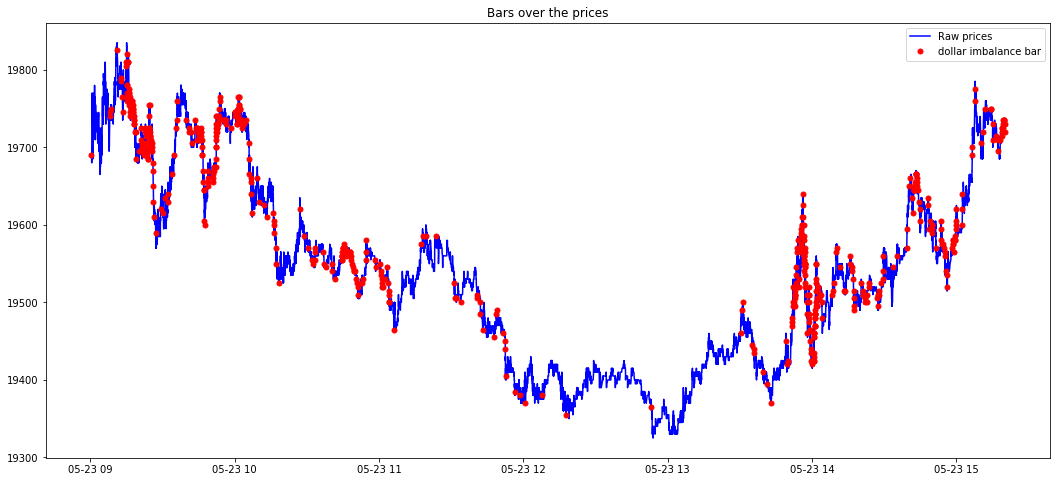

In [183]:
plot_bars(df_sub, dib_sub, 'dollar imbalance bar')

## Apply triple barrier

In [184]:
dib.index = pd.to_datetime(dib.index)

In [330]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=dib['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(dib['close'], threshold=daily_vol['2018-01-01':'2018-05-01'].mean()*0.5)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=dib['close'], num_days=1)

In [186]:
print(dib.shape)
print(cusum_events.shape)
print(vertical_barriers.shape)

(187149, 5)
(21339,)
(21229,)


In [187]:
dib.head()

,open,high,low,close,volume
date_time,,,,,
2018-01-02 10:03:33.036,19800.0,20220.0,19800.0,20075.0,877248
2018-01-02 10:06:38.907,20075.0,20130.0,19975.0,19975.0,398672
2018-01-02 10:08:17.939,19975.0,19985.0,19860.0,19860.0,166765
2018-01-02 10:16:26.609,19860.0,20080.0,19805.0,19955.0,644184
2018-01-02 10:22:12.707,19955.0,20065.0,19945.0,19945.0,347232


## Build label

In [188]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=dib['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers)

/mnt/afml/mlfinlab/mlfinlab/labeling/labeling.py:117: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-05-23 16:14:53.967628 100.0% apply_pt_sl_on_t1 done after 0.18 minutes. Remaining 0.0 minutes.


In [198]:
labels = ml.labeling.get_bins(triple_barrier_events, dib['close'])

In [201]:
labels.bin.value_counts()

-1    3485
 1    2833
 0     575
Name: bin, dtype: int64

## Features

In [202]:
raw_data = dib.copy()

In [203]:
raw_data.head()

,open,high,low,close,volume
date_time,,,,,
2018-01-02 10:03:33.036,19800.0,20220.0,19800.0,20075.0,877248
2018-01-02 10:06:38.907,20075.0,20130.0,19975.0,19975.0,398672
2018-01-02 10:08:17.939,19975.0,19985.0,19860.0,19860.0,166765
2018-01-02 10:16:26.609,19860.0,20080.0,19805.0,19955.0,644184
2018-01-02 10:22:12.707,19955.0,20065.0,19945.0,19945.0,347232


In [327]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [205]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

In [206]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

y = labels['bin']

## Balance classes

In [208]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [221]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-01':'2018-10-01']
y_training_validation = y['2018-01-01':'2018-10-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.15, shuffle=False)

In [222]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

-1    1880
 1    1658
 0     382
Name: bin, dtype: int64

In [ ]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
"""
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()
"""
# class별 blanace 필요

In [223]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

## Fit a model

In [230]:
parameters = {'max_depth':[2, 3, 4],
              'n_estimators':[1, 10],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [231]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.48112245 0.49566327 0.49413265 0.49438776 0.49489796 0.49311224
 0.49362245 0.47678571 0.49489796 0.50280612 0.50484694 0.49923469
 0.49489796 0.49591837 0.47729592 0.48979592 0.49362245 0.50280612
 0.50739796 0.50433673 0.50280612 0.47627551 0.49081633 0.49566327
 0.49617347 0.49770408 0.49642857 0.49744898 0.46836735 0.48877551
 0.48494898 0.48928571 0.49234694 0.48877551 0.49030612]
100 4 42


In [232]:
# Refit a new model with best params, so we can see feature importance
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Training metrics

In [250]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
x_side = y_pred
#fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

# plt.figure(1)
# plt.plot([-1, 1], [-1, 1], 'k--')
# plt.plot(fpr_rf, tpr_rf, label='RF')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

              precision    recall  f1-score   support

          -1       0.53      0.82      0.64      1880
           0       0.84      0.31      0.46       382
           1       0.56      0.30      0.39      1658

    accuracy                           0.55      3920
   macro avg       0.64      0.48      0.50      3920
weighted avg       0.57      0.55      0.52      3920

Confusion Matrix
[[1539   12  329]
 [ 209  119   54]
 [1158   10  490]]

Accuracy
0.5479591836734694


## Validation metrics

In [255]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
x_side = np.concatenate([x_side, y_pred])
# fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rf, tpr_rf, label='RF')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

              precision    recall  f1-score   support

          -1       0.50      0.72      0.59       351
           0       0.00      0.00      0.00        35
           1       0.43      0.23      0.30       306

    accuracy                           0.47       692
   macro avg       0.31      0.32      0.30       692
weighted avg       0.45      0.47      0.43       692

Confusion Matrix
[[254  17  80]
 [ 24   0  11]
 [225  11  70]]

Accuracy
0.4682080924855491


In [237]:
print(X_validate.index.min())
print(X_validate.index.max())

2018-08-08 10:33:52.673000
2018-10-01 12:59:09.410000


In [242]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      3485
           0       0.00      0.00      0.00       575
           1       0.41      1.00      0.58      2833

    accuracy                           0.41      6893
   macro avg       0.14      0.33      0.19      6893
weighted avg       0.17      0.41      0.24      6893

Confusion Matrix
[[   0    0 3485]
 [   0    0  575]
 [   0    0 2833]]

Accuracy
0.41099666328159


/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


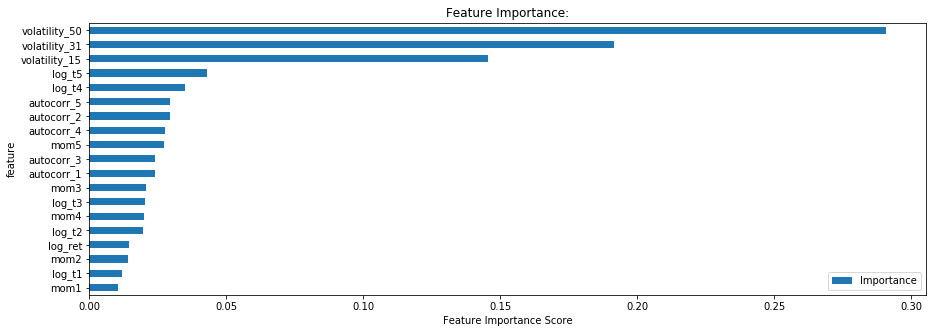

In [243]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

## Meta Labeling

In [332]:
dib.head()

,open,high,low,close,volume
date_time,,,,,
2018-01-02 10:03:33.036,19800.0,20220.0,19800.0,20075.0,877248
2018-01-02 10:06:38.907,20075.0,20130.0,19975.0,19975.0,398672
2018-01-02 10:08:17.939,19975.0,19985.0,19860.0,19860.0,166765
2018-01-02 10:16:26.609,19860.0,20080.0,19805.0,19955.0,644184
2018-01-02 10:22:12.707,19955.0,20065.0,19945.0,19945.0,347232


In [ ]:
raw_data = dib.copy()

# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Remove look ahead bias
raw_data = raw_data.shift(1)


In [340]:
raw_data.head()

,log_ret,mom1,mom2,mom3,mom4,mom5,volatility_50,volatility_31,volatility_15,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5
date_time,,,,,,,,,,,,,,,,,,,
2018-01-02 11:27:50.516,0.000000,0.000000,0.000248,0.000248,-0.000496,-0.000744,0.001884,0.000551,0.000482,0.074874,-0.292370,0.073187,0.225867,-0.453230,0.000248,0.000000,-0.000745,-0.000248,-0.000248
2018-01-02 11:28:12.241,0.000496,0.000497,0.000497,0.000745,0.000745,0.000000,0.001738,0.000551,0.000493,-0.145542,-0.151532,0.048053,0.115563,-0.438703,0.000000,0.000248,0.000000,-0.000745,-0.000248
2018-01-02 11:28:15.993,0.000000,0.000000,0.000497,0.000497,0.000745,0.000745,0.001511,0.000548,0.000491,0.082997,-0.216425,-0.130743,0.213517,-0.083320,0.000496,0.000000,0.000248,0.000000,-0.000745
2018-01-02 11:28:18.324,0.000000,0.000000,0.000000,0.000497,0.000497,0.000745,0.001366,0.000544,0.000489,0.127542,-0.095824,-0.211044,-0.224572,-0.105333,0.000000,0.000496,0.000000,0.000248,0.000000
2018-01-02 11:28:26.489,-0.000248,-0.000248,-0.000248,-0.000248,0.000248,0.000248,0.001364,0.000522,0.000495,0.111211,-0.085247,-0.251045,-0.221313,-0.089478,0.000000,0.000000,0.000496,0.000000,0.000248


In [ ]:
X = raw_data

X.dropna(inplace=True)

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)


In [341]:
total_predict = rf.predict(X)

In [345]:
total_predict.shape

(187098,)

In [347]:
dib2 = dib.loc[X.index]

In [352]:
dib2['side'] = total_predict

In [353]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=dib2['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=dib2['side'])

2019-05-24 09:24:40.530318 100.0% apply_pt_sl_on_t1 done after 0.19 minutes. Remaining 0.0 minutes.


In [356]:
triple_barrier_events.head()

,side,t1,trgt
2018-01-03 13:39:37.494,-1.0,2018-01-03 13:52:16.358,0.005259
2018-01-03 13:47:09.291,-1.0,2018-01-03 13:52:16.358,0.005986
2018-01-03 13:49:24.704,-1.0,2018-01-03 13:52:43.062,0.006505
2018-01-03 13:52:16.358,-1.0,2018-01-03 13:53:09.990,0.007453
2018-01-03 13:52:43.062,-1.0,2018-01-03 13:57:57.724,0.008619


In [355]:
labels = ml.labeling.get_bins(triple_barrier_events, dib2['close'])
labels.side.value_counts()

-1.0    5133
 1.0    1506
 0.0     245
Name: side, dtype: int64

In [358]:
labels.bin.value_counts()

1    4281
0    2603
Name: bin, dtype: int64